# Your first neural network

Neste projeto, você irá construir sua primeira rede neural e usá-la para prever o rendimento diário de aluguel de bicicletas. Nós fornecemos algum código, mas deixamos a implementação da rede neural até você (na sua maioria). Depois de enviar este projeto, sinta-se livre para explorar os dados e o modelo mais


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

Um passo crítico no trabalho com redes neurais é preparar os dados corretamente. As variáveis em diferentes escalas tornam difícil para a rede aprender com eficiência os pesos corretos. Abaixo, escrevemos o código para carregar e preparar os dados. Você aprenderá mais sobre isso em breve!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

Este conjunto de dados tem o número de pilotos para cada hora de cada dia de 1 de janeiro de 2011 a 31 de dezembro de 2012. O número de pilotos é dividido entre casual e registrado, resumido na coluna `cnt`. Você pode ver as primeiras linhas dos dados acima.

Abaixo está um gráfico que mostra o número de ciclistas durante os primeiros 10 dias ou mais no conjunto de dados. (Alguns dias não têm exatamente 24 entradas no conjunto de dados, portanto, não são exatamente 10 dias.) Você pode ver os aluguéis por hora aqui. Estes dados são bastante complicados! Os fins de semana são mais baixos em todo o número de pessoas e há picos quando as pessoas estão caminhando para o trabalho durante a semana. Olhando para os dados acima, também temos informações sobre temperatura, umidade e velocidade do vento, tudo isso provavelmente afetando o número de cavaleiros. Você estará tentando capturar tudo isso com seu modelo.

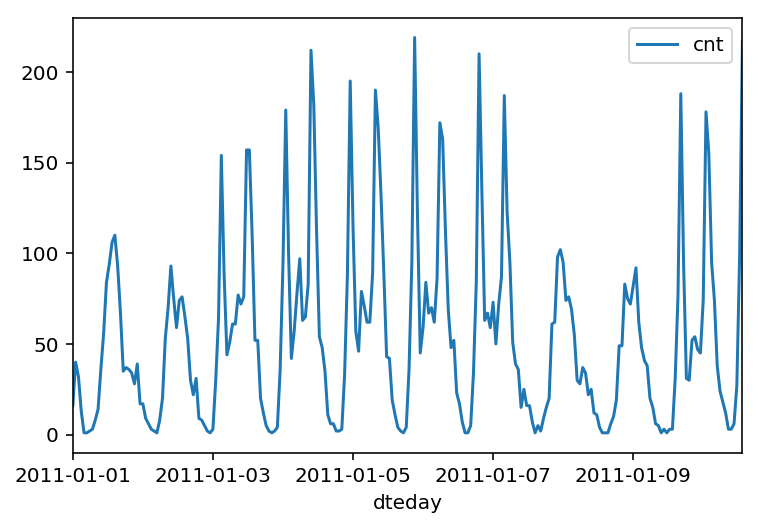

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Aqui temos algumas variáveis categóricas como estação, clima, mês. Para incluí-los em nosso modelo, precisaremos fazer variáveis binárias. Isso é simples de fazer com as Pandas graças a `get_dummies ()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
Para facilitar o treinamento da rede, padronizaremos cada uma das variáveis contínuas. Ou seja, vamos mudar e dimensionar as variáveis de forma que tenham uma média zero e um desvio padrão de 1.

Os fatores de escala são salvos para que possamos ir para trás quando usamos a rede para previsões.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

Vamos salvar os dados nos últimos aproximadamente 21 dias para usar como um conjunto de testes depois de treinarmos a rede. Usaremos este conjunto para fazer previsões e compará-los com o número real de pilotos.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

Vamos dividir os dados em dois conjuntos, um para treinamento e outro para validação à medida que a rede está sendo treinada. Uma vez que se trata de dados da série temporal, vamos treinar nos dados históricos e tentar prever sobre os dados futuros (o conjunto de validação).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Abaixo você irá construir sua rede. Construímos a estrutura e a passagem para trás. Você implementará o passar para a frente pela rede. Você também configurará os hiperparâmetros: a taxa de aprendizado, o número de unidades escondidas eo número de treinamentos passam.

<img src="assets/neural_network.png" width=300px>

A rede possui duas camadas, uma camada oculta e uma camada de saída. A camada oculta usará a função sigmoid para ativações. A camada de saída tem apenas um nó e é usada para a regressão, a saída do nó é igual à entrada do nó. Ou seja, a função de ativação é $ f (x) = x $. Uma função que leva o sinal de entrada e gera um sinal de saída, mas leva em consideração o limite, é chamada de função de ativação. Trabalhamos através de cada camada da nossa rede calculando as saídas para cada neurônio. Todas as saídas de uma camada tornam-se entradas para os neurônios na próxima camada. Este processo é chamado *forward propagation*.

Utilizamos os pesos para propagar os sinais para a frente da entrada para as camadas de saída em uma rede neural. Usamos os pesos para propagar também o erro de trás da saída para a rede para atualizar nossos pesos. Isso é chamado *backpropagation*.

> **Hint:** Você precisará da derivada da função de ativação de saída ($f(x) = x$) for the backpropagation implementation.Se você não está familiarizado com o cálculo, esta função é equivalente à equação $y = x$. Qual é a inclinação dessa equação? Essa é a derivada de $f(x)$.

Abaixo, você tem essas tarefas:
1. Implemente a função sigmoid para usar como função de ativação. Configure `self.activation_function` em` __init__` para sua função sigmoid.
2. Implementar a passagem para avanço no método `train`.
3. Implementar o algoritmo de backpropagation no método `train`, incluindo o cálculo do erro de saída.
4. Implemente a passagem para a frente no método `run`.
  

In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))  # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        #def sigmoid(x):
        #    return 0  # Replace 0 with your sigmoid calculation here
        #self.activation_function = sigmoid
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            #### Implement the forward pass here ####
            ### Forward pass ###
            # TODO: Hidden layer - Replace these values with your calculations.
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

            # TODO: Output layer - Replace these values with your calculations.
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # TODO: Output error - Replace this value with your calculations.
            error = y - final_outputs # Output layer error is the difference between desired target and actual output.

            # TODO: Calculate the hidden layer's contribution to the error
            hidden_error = np.dot(error, self.weights_hidden_to_output.T)
            
            # TODO: Backpropagated error terms - Replace these values with your calculations.
            output_error_term = error 
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)

            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:,None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:,None]

        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr *  delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Execute esses testes de unidade para verificar a correção da sua implementação de rede. Isso irá ajudá-lo a garantir que sua rede tenha sido implementada corretamente antes de começar a tentar treiná-la. Esses testes devem ser bem sucedidos para aprovar o projeto.

In [11]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Aqui você configurará os hiperparâmetros da rede. A estratégia aqui é encontrar hiperparâmetros, de modo que o erro no conjunto de treinamento seja baixo, mas você não está superando os dados. Se você treinar a rede por muito tempo ou tiver muitos nós ocultos, pode tornar-se excessivamente específico para o conjunto de treinamento e não conseguirá generalizar para o conjunto de validação. Ou seja, a perda no conjunto de validação começará a aumentar à medida que a queda do conjunto de treinamento cai.

Você também usará um método conhecido como Descida de gradiente estocástica (SGD) para treinar a rede. A idéia é que, para cada passagem de treinamento, você pega uma amostra aleatória dos dados em vez de usar todo o conjunto de dados. Você usa muitas mais passagens de treinamento do que com descendência de gradiente normal, mas cada passagem é muito mais rápida. Isso acaba treinando a rede de forma mais eficiente. Você aprenderá mais sobre o SGD mais tarde.

### Choose the number of iterations
Este é o número de lotes de amostras dos dados de treinamento que usaremos para treinar a rede. Quanto mais iterações você usa, melhor o modelo irá caber nos dados. No entanto, se você usar muitas iterações, então o modelo com não generalizar bem para outros dados, isso é chamado de superação. Você quer encontrar um número aqui onde a rede possui uma baixa perda de treinamento e a perda de validação é mínima. À medida que você começa a superar, você verá que a perda de treinamento continua a diminuir enquanto a perda de validação começa a aumentar.

### Choose the learning rate
Isso reduz o tamanho das atualizações de peso. Se isso é muito grande, os pesos tendem a explodir e a rede não consegue se ajustar aos dados. Uma boa escolha para começar é 0.1. Se a rede tiver problemas ao ajustar os dados, tente reduzir a taxa de aprendizado. Note-se que quanto menor for a taxa de aprendizagem, menores as etapas estão nas atualizações de peso e quanto mais demora a convergir a rede neural.

### Choose the number of hidden nodes
Os nós mais ocultos que você tem, as previsões mais precisas que o modelo fará. Experimente alguns números diferentes e veja como isso afeta o desempenho. Você pode observar o dicionário de perdas para uma métrica da performance da rede. Se o número de unidades escondidas for muito baixo, então o modelo não terá espaço suficiente para aprender e, se for muito alto, há muitas opções para a direção que a aprendizagem pode levar. O truque aqui é encontrar o equilíbrio certo no número de unidades escondidas que você escolher.

In [12]:
import sys

### Set the hyperparameters here ###
iterations = 2500
learning_rate = 0.1
hidden_nodes = 14
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.273 ... Validation loss: 0.447

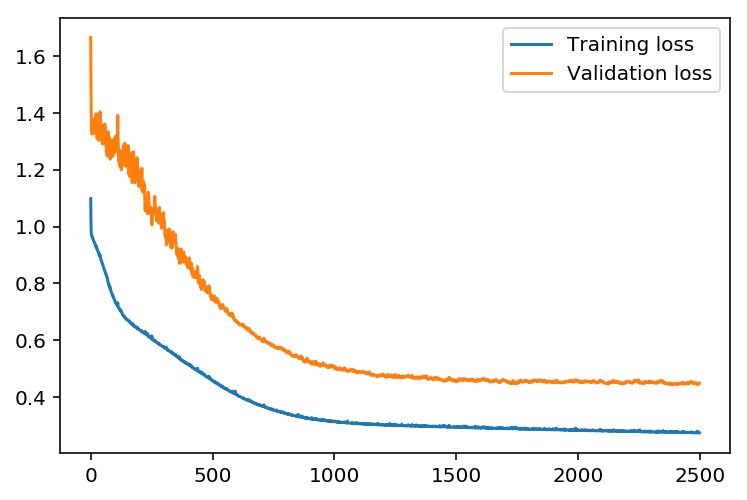

In [13]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Aqui, use os dados do teste para ver como sua rede está modelando os dados. Se algo estiver completamente errado, certifique-se de que cada etapa da sua rede esteja implementada corretamente.

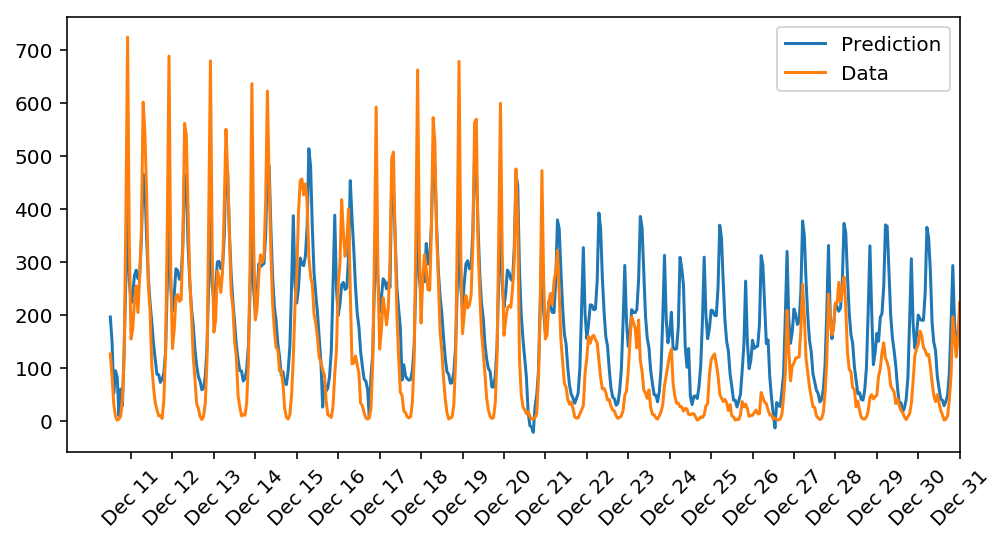

In [14]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).

Responda estas perguntas sobre seus resultados. Quão bem o modelo prediz os dados? Onde ele falha? Por que ele falha onde ele faz?

> **Note:** Você pode editar o texto nesta célula clicando duas vezes nele. Quando quiser renderizar o texto, pressione controle + digite

#### Your answer below

O modelo é bastante preciso na maioria das vezes, mas começa a falhar um pouco depois de 21 de dezembro. Provavelmente isso é devido à despedida da norma durante a temporada de férias. Durante as férias (em torno de 25 de dezembro), o modelo é uma falta, prevendo que haverá uma corrida na manhã e na tarde.

## Personal insight

#### Training multiple networks for different combinations of learning rates and hidden nodes.

In [15]:
import sys

### Set the hyperparameters here ###
iterations = 2000
learning_rate_list = [0.05, 0.075, 0.1, 0.125, 0.15]
hidden_nodes_list = [1, 4, 7, 14, 28, 42, 56]
output_nodes = 1

total_iterations = float(iterations * len(learning_rate_list) * len(hidden_nodes_list))
cnt = 0
losses_h = []
network_h = []
for hidden_nodes in hidden_nodes_list:
    losses_lr = []
    network_lr = []
    for learning_rate in learning_rate_list:
        N_i = train_features.shape[1]
        network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

        losses = {'train':[], 'validation':[]}
        for ii in range(iterations):
            cnt+=1
            # Go through a random batch of 128 records from the training data set
            batch = np.random.choice(train_features.index, size=128)
            X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                                 
            network.train(X, y)
    
            # Printing out the training progress
            train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
            val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
            sys.stdout.write("\rTotal Progress: {:2.1f}".format(100 * cnt/total_iterations)
                         + "% ... Progress: {:2.1f}".format(100 * ii/float(iterations)) \
                         + "% ... Iterations: {}".format(iterations) \
                         + " ... Hidden Nodes: {}".format(hidden_nodes) \
                         + " ... LearningRate: {}".format(learning_rate) \
                         + " ... Training loss: " + str(train_loss)[:5] \
                         + " ... Validation loss: " + str(val_loss)[:5])
            sys.stdout.flush()
    
            losses['train'].append(train_loss)
            losses['validation'].append(val_loss)
        
        losses_lr.append(losses)
        network_lr.append(network)
    losses_h.append(losses_lr)
    network_h.append(network_lr)

Total Progress: 100.0% ... Progress: 100.0% ... Iterations: 2000 ... Hidden Nodes: 56 ... LearningRate: 0.15 ... Training loss: 0.286 ... Validation loss: 0.451

### Visualising the traning loss and validation loss for the cobinations

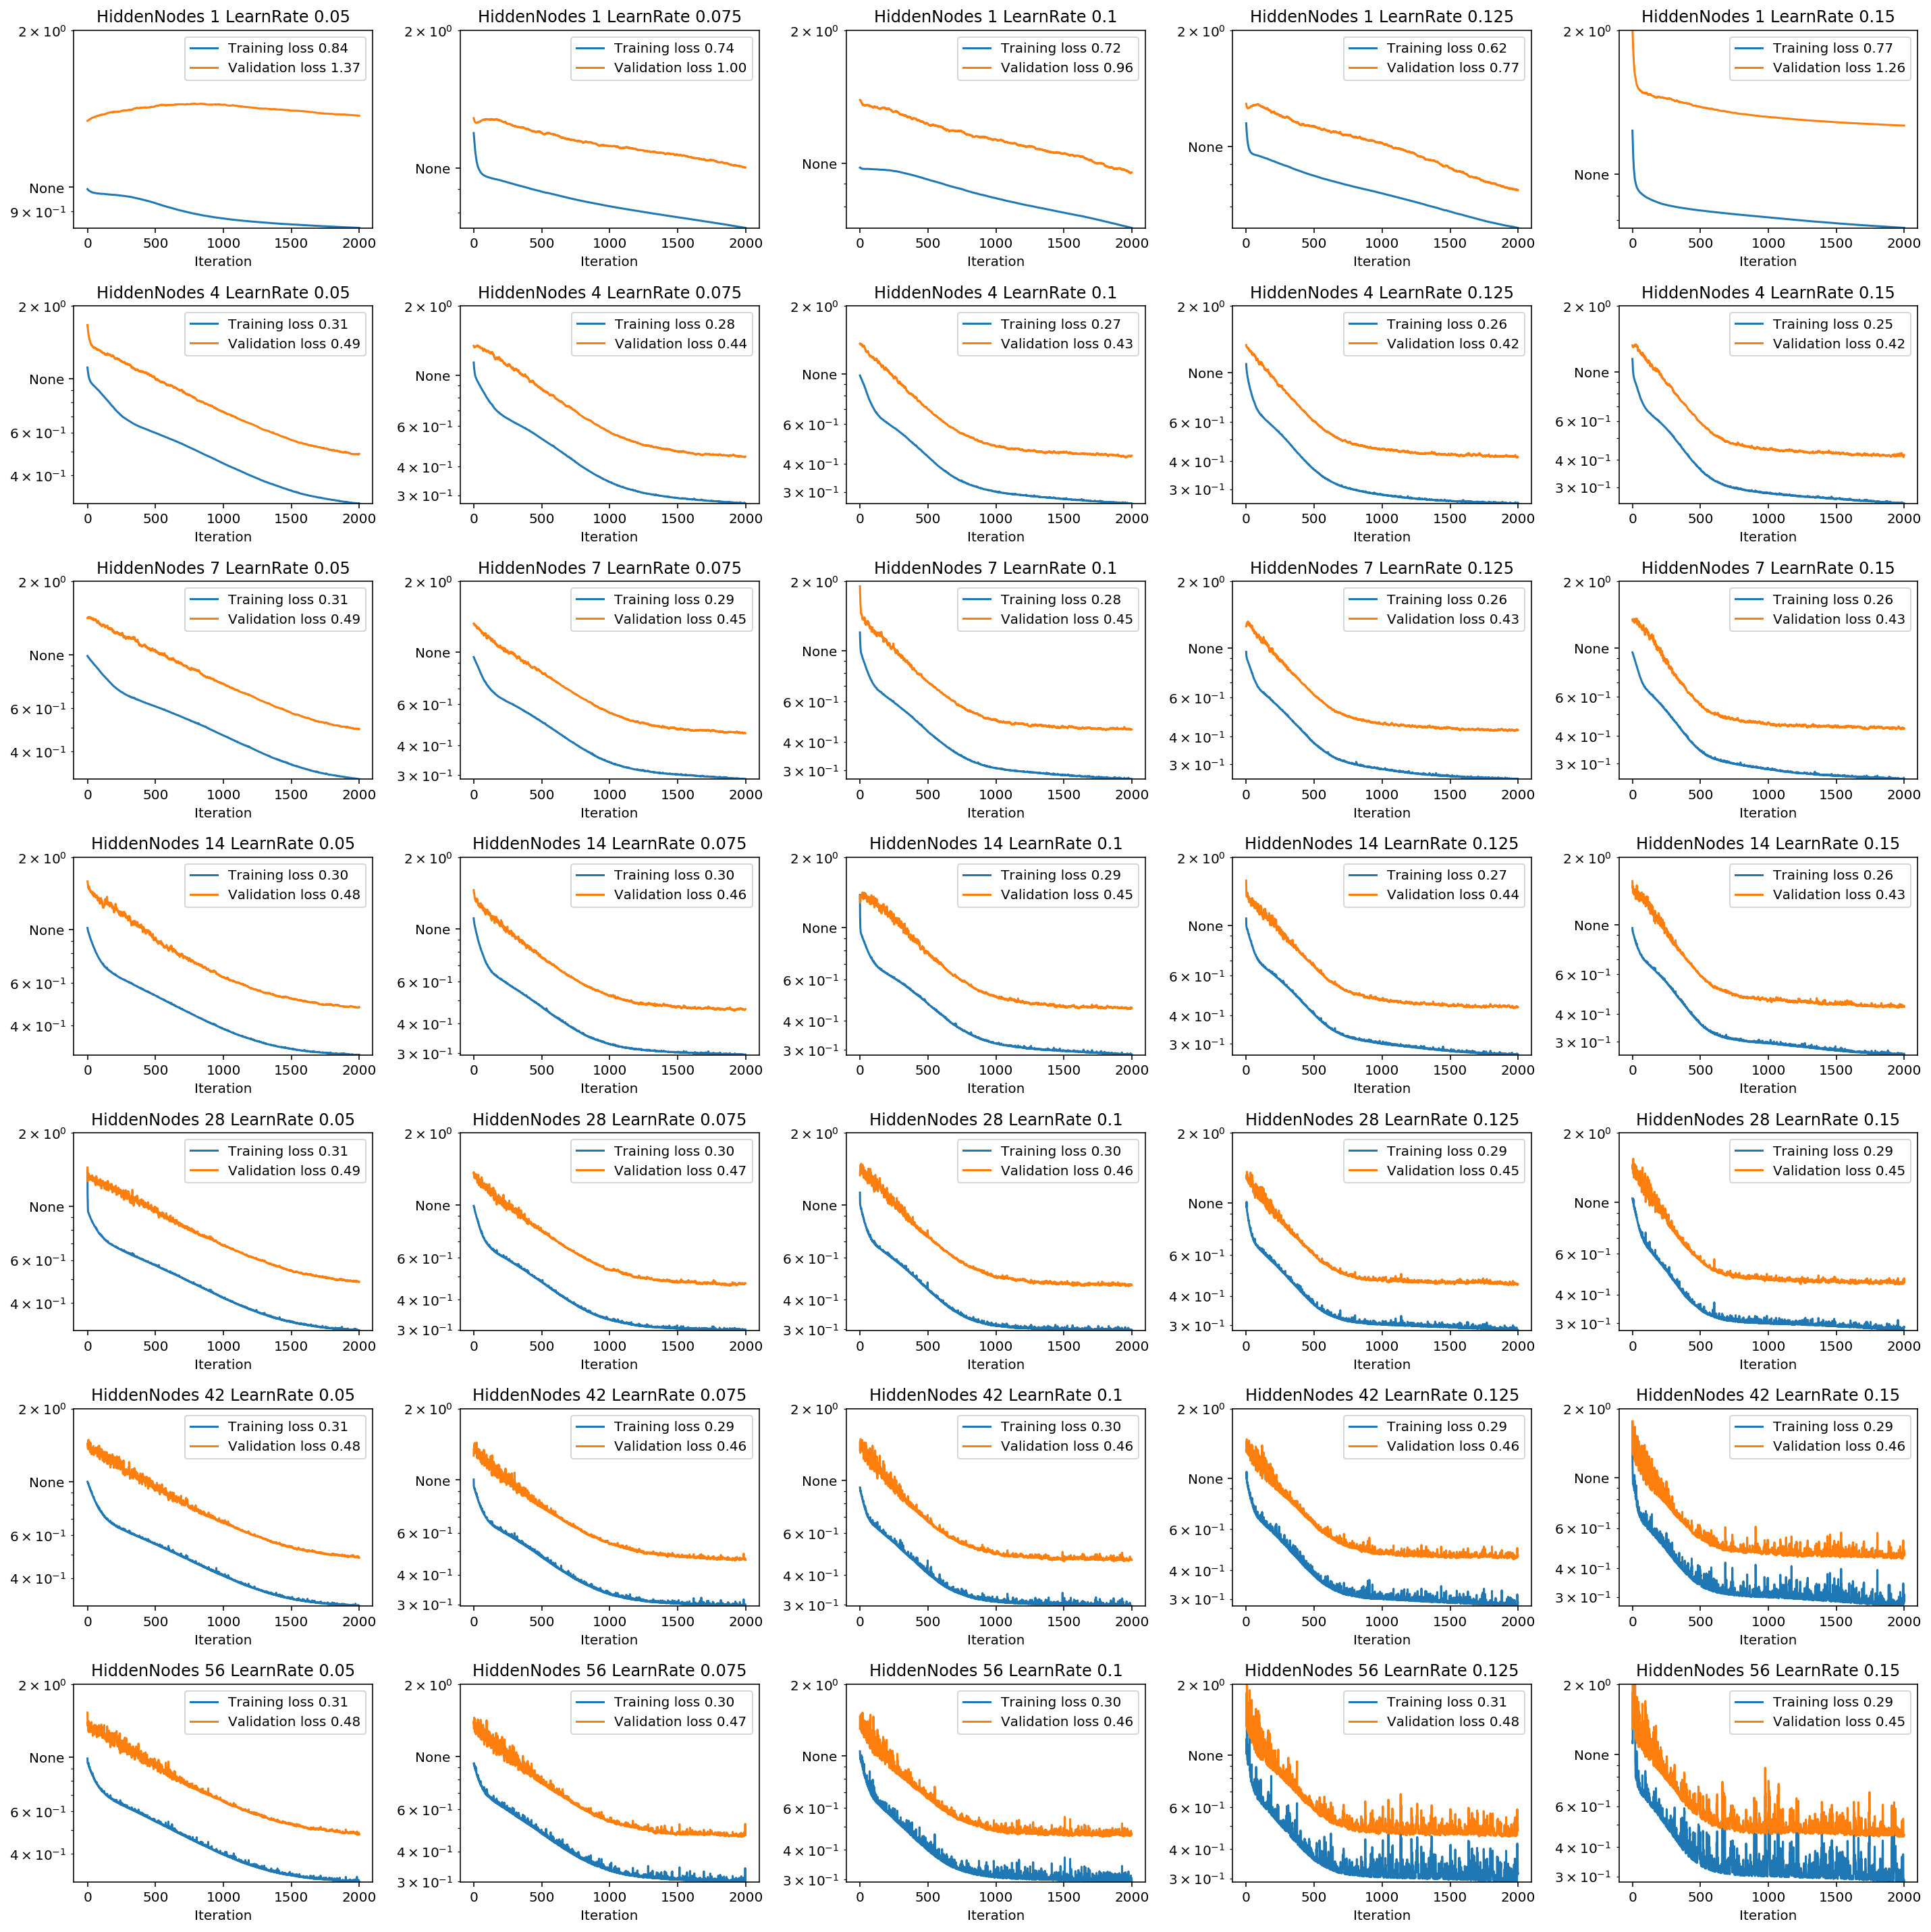

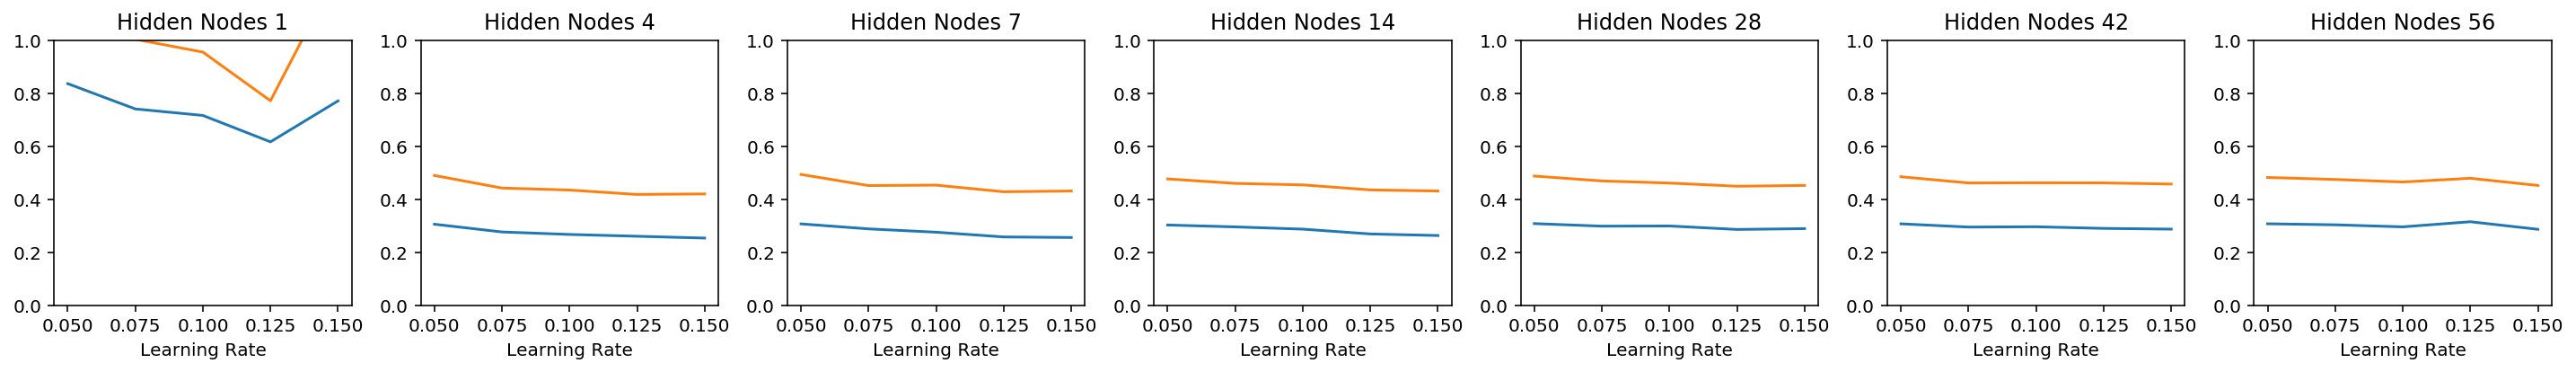

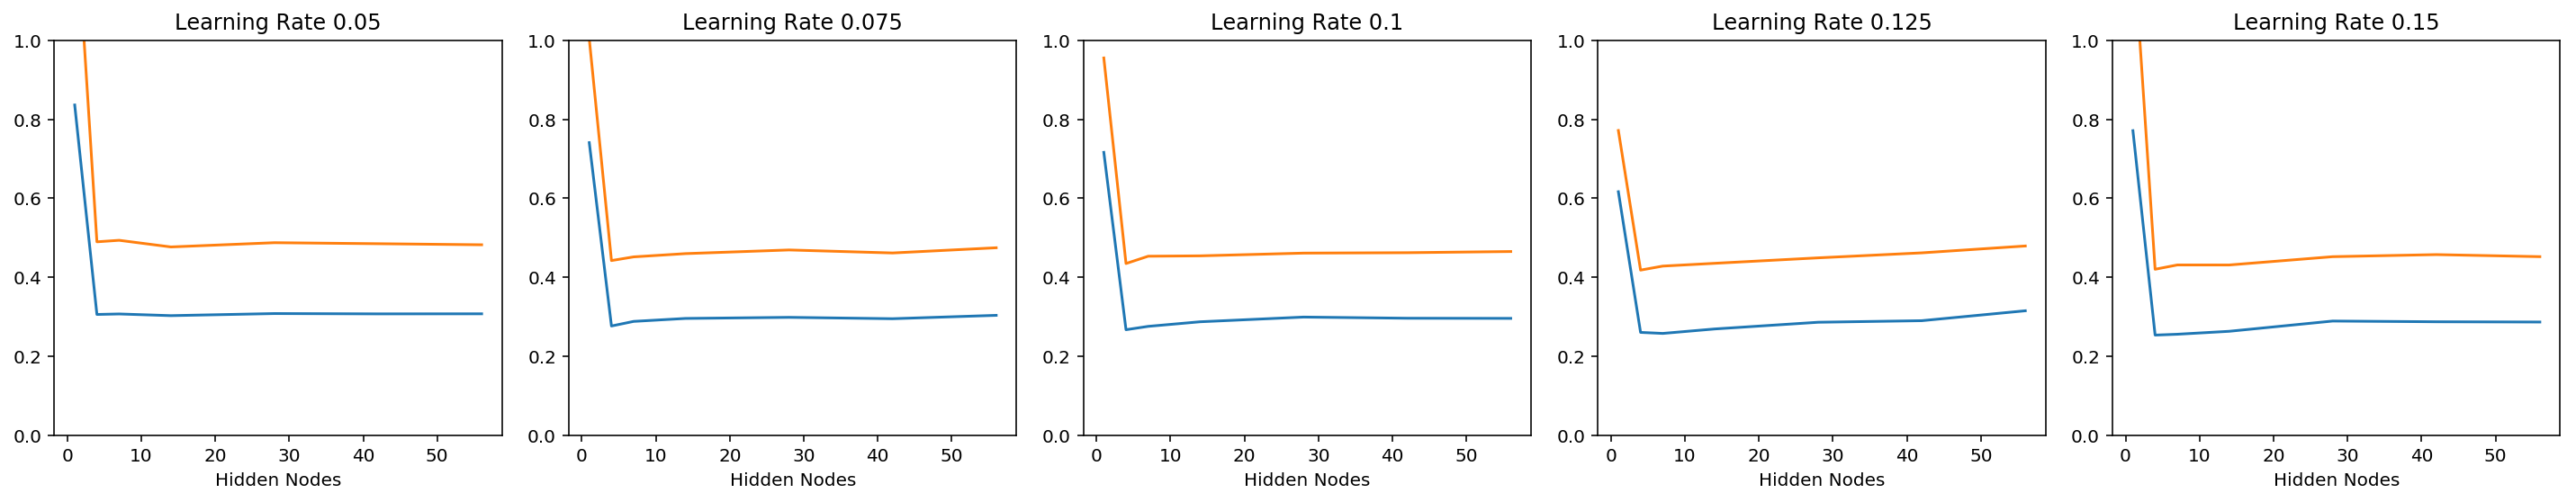

In [16]:
final_train_loss = []
final_validation_loss = []

formatter = plt.LogFormatter()

fig, axes = plt.subplots(len(hidden_nodes_list),len(learning_rate_list),figsize=(20, 20))
for i, losses_lr, hidden_nodes in zip(range(len(hidden_nodes_list)), losses_h, hidden_nodes_list):
    temp_train_loss = []
    temp_validation_loss = []
    for j, losses, learning_rate in zip(range(len(learning_rate_list)), losses_lr, learning_rate_list):

        axes[i,j].plot(losses['train'], label='Training loss {:1.2f}'.format(losses['train'][-1]))
        axes[i,j].plot(losses['validation'], label='Validation loss {:1.2f}'.format(losses['validation'][-1]))
        axes[i,j].legend()
        axes[i,j].set_title("HiddenNodes {} LearnRate {}".format(hidden_nodes,learning_rate))
        axes[i,j].set_yscale('log')
        axes[i,j].set_xlabel("Iteration")
        axes[i,j].set_ylim([0,2])
        axes[i,j].get_yaxis().set_major_formatter(formatter)
        temp_train_loss.append(losses['train'][-1])
        temp_validation_loss.append(losses['validation'][-1])
        
    final_train_loss.append(temp_train_loss)
    final_validation_loss.append(temp_validation_loss)
        
fig.tight_layout()
    
fig1, axes1 = plt.subplots(1,len(hidden_nodes_list),figsize=(20, 3))
for i,hidden_nodes in zip(range(len(hidden_nodes_list)),hidden_nodes_list):
    axes1[i].plot(learning_rate_list,final_train_loss[i],label="Training loss")
    axes1[i].plot(learning_rate_list,final_validation_loss[i],label="Validation loss")
    axes1[i].set_ylim([0,1])
    axes1[i].set_xlabel("Learning Rate")
    axes1[i].set_title("Hidden Nodes {}".format(hidden_nodes))


fig1.tight_layout()

fig2, axes2 = plt.subplots(1,len(learning_rate_list),figsize=(20, 4))
for i,learning_rate in zip(range(len(learning_rate_list)),learning_rate_list):
    axes2[i].plot(hidden_nodes_list,[row[i] for row in final_train_loss],label="Training loss")
    axes2[i].plot(hidden_nodes_list,[row[i] for row in final_validation_loss],label="Validation loss")
    axes2[i].set_ylim([0,1])
    axes2[i].set_xlabel("Hidden Nodes")
    axes2[i].set_title("Learning Rate {}".format(learning_rate))

fig2.tight_layout()

### Visualising the predictions of the different combinations

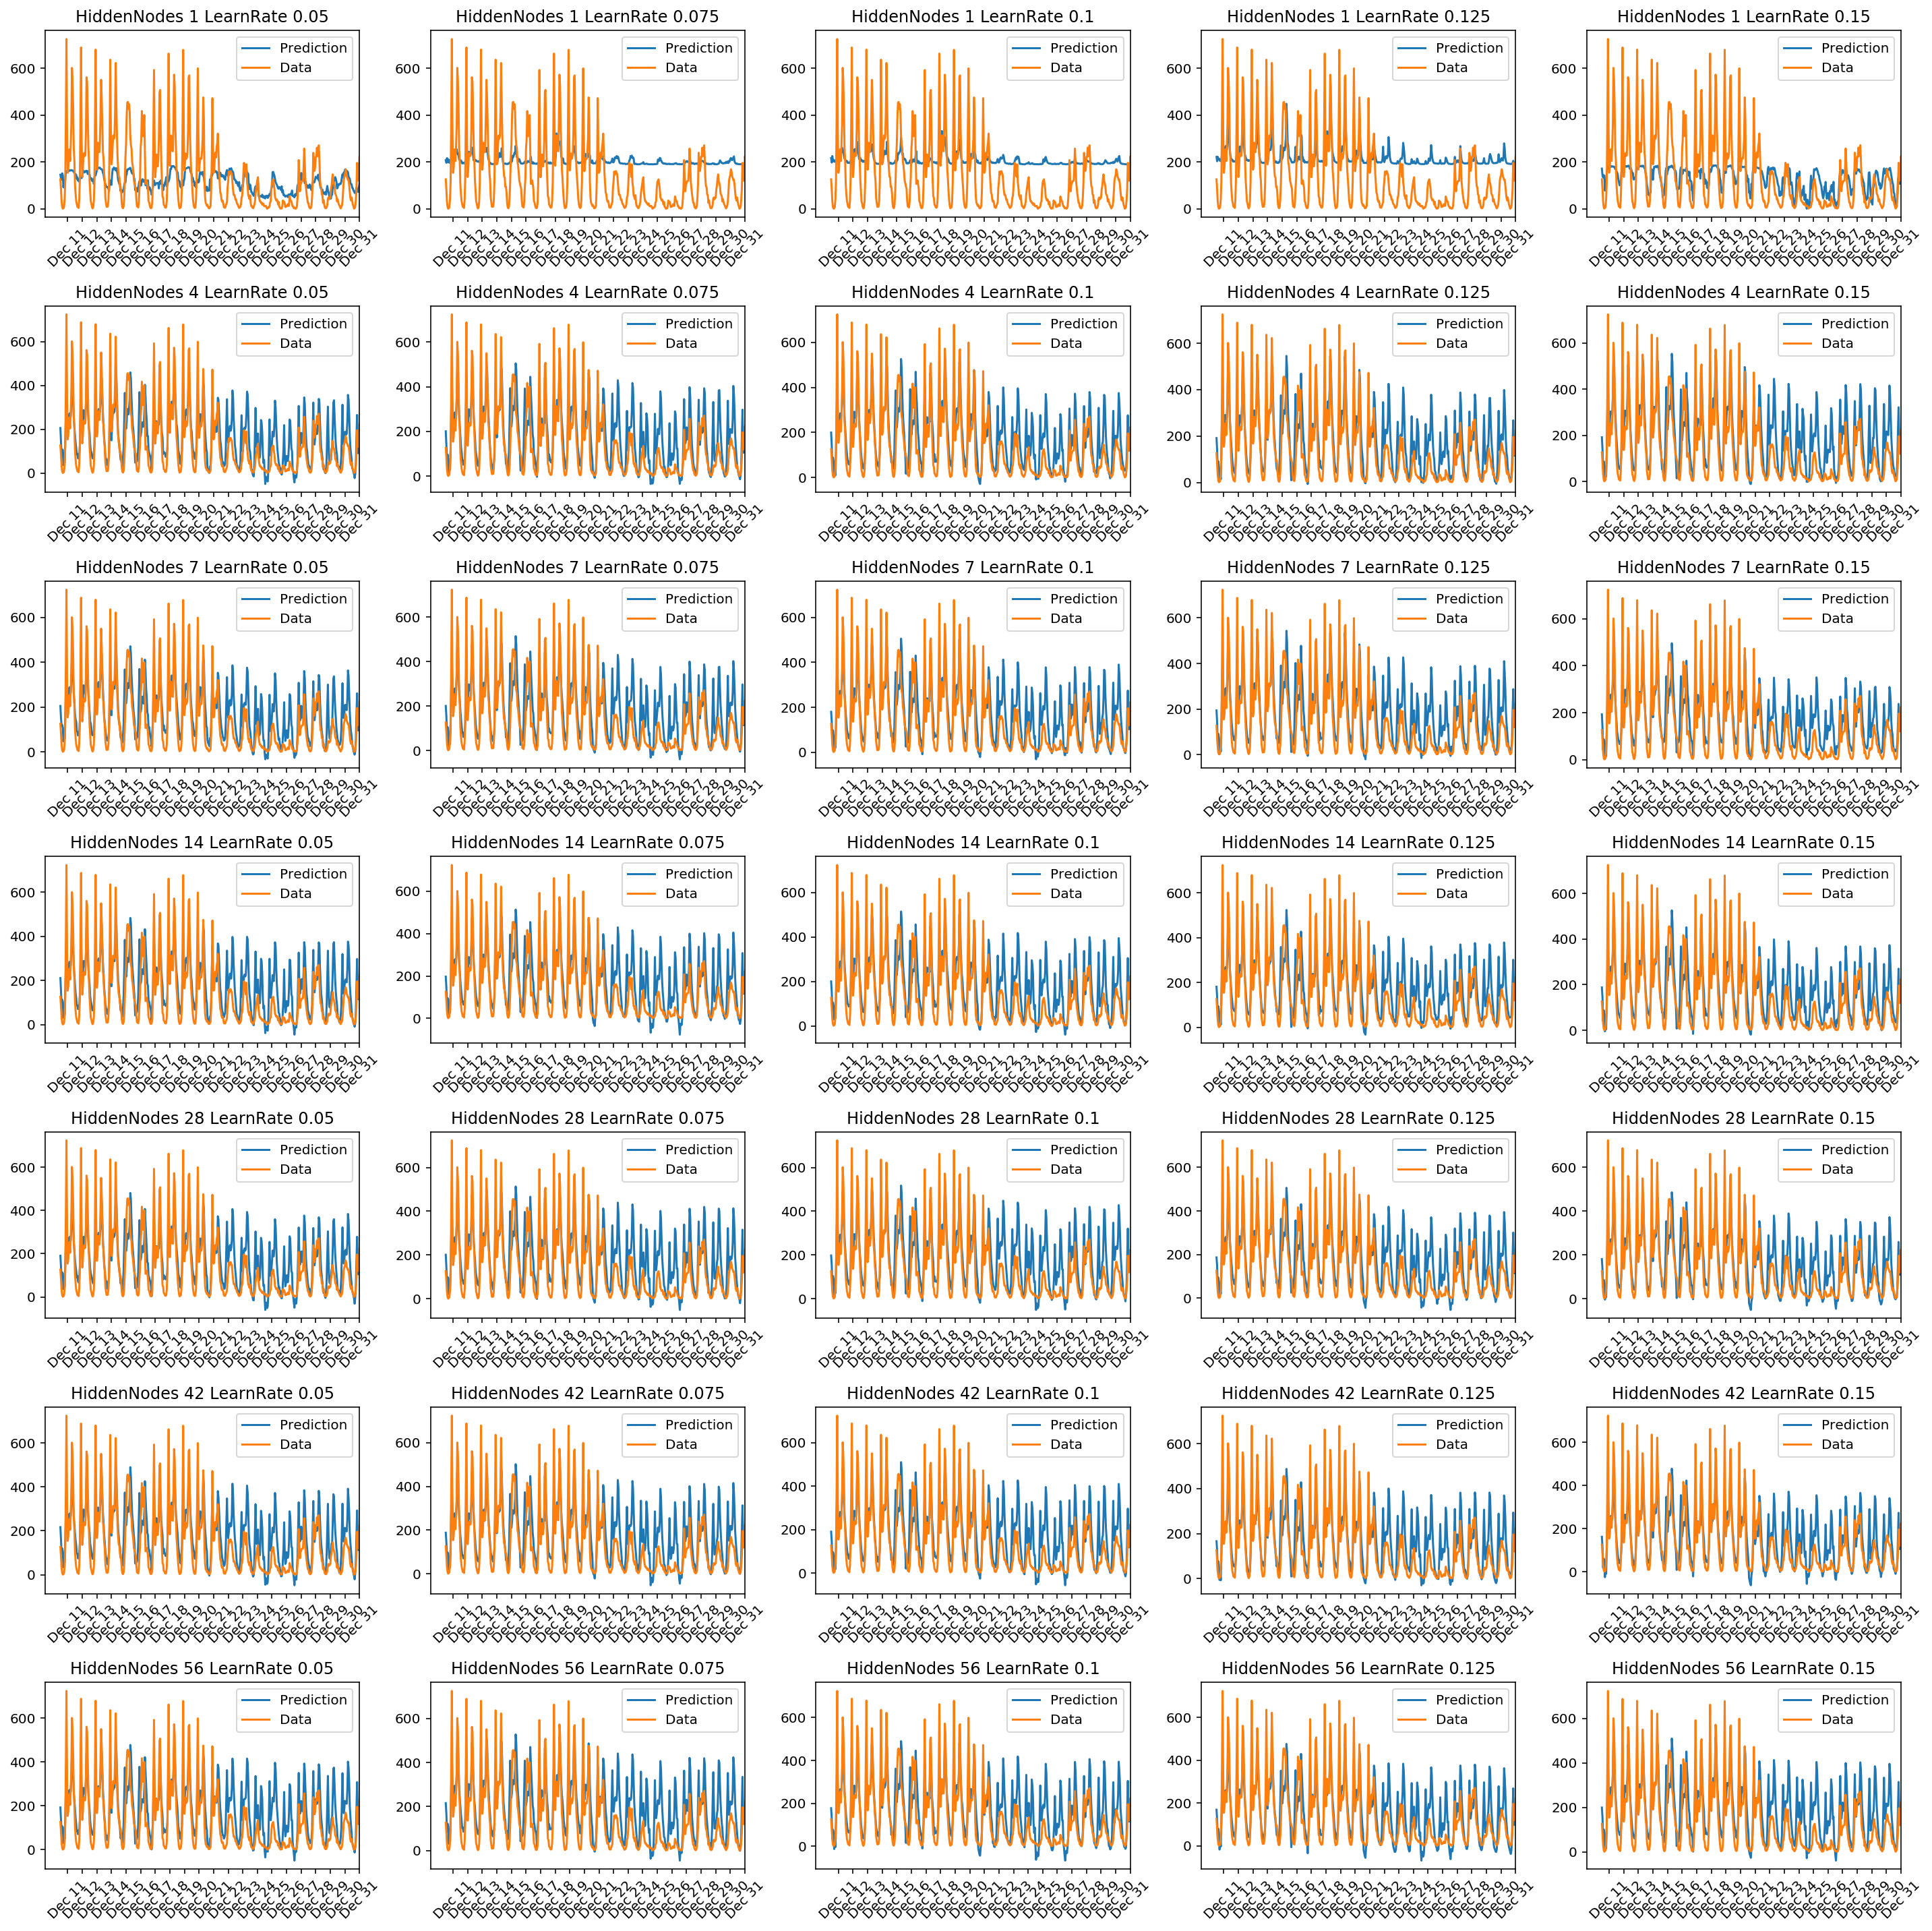

In [17]:
fig, ax = plt.subplots(len(hidden_nodes_list),len(learning_rate_list),figsize=(20, 20))
for i, network_lr, hidden_nodes in zip(range(len(hidden_nodes_list)), network_h, hidden_nodes_list):
    for j, network, learning_rate in zip(range(len(learning_rate_list)), network_lr, learning_rate_list):

# fig, ax = plt.subplots(figsize=(8,4))

        mean, std = scaled_features['cnt']
        predictions = network.run(test_features).T*std + mean
        ax[i,j].plot(predictions[0], label='Prediction')
        ax[i,j].plot((test_targets['cnt']*std + mean).values, label='Data')
        ax[i,j].set_xlim(right=len(predictions))
        ax[i,j].legend()
        ax[i,j].set_title("HiddenNodes {} LearnRate {}".format(hidden_nodes,learning_rate))
        dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
        dates = dates.apply(lambda d: d.strftime('%b %d'))
        ax[i,j].set_xticks(np.arange(len(dates))[12::24])
        _ = ax[i,j].set_xticklabels(dates[12::24], rotation=45)
_ = fig.tight_layout()